In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
from torchvision.transforms import functional as F
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Functie om bounding boxes te voorspellen met Faster R-CNN
def predict_bounding_boxes(images, model, device):
    model.eval()
    with torch.no_grad():
        predictions = model([F.to_tensor(image).to(device) for image in images])
    return [prediction['boxes'].cpu().numpy() for prediction in predictions]

# Functie om één afbeelding en annotaties te verwerken
def process_single_image(filename, image_dir, model, device):
    image_path = os.path.join(image_dir, filename)
    image = Image.open(image_path).convert('RGB')
    bounding_boxes = predict_bounding_boxes([np.array(image)], model, device)[0]
    annotations = [[filename, *box] for box in bounding_boxes]
    return annotations

# Functie om afbeeldingen en annotaties te verwerken met multi-threading
def annotate_images(image_dir, model, output_csv, device, num_workers=4):
    annotations = []
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_single_image, filename, image_dir, model, device) for filename in image_files]
        for future in tqdm(futures, desc="Annotating images", total=len(image_files)):
            annotations.extend(future.result())
    
    # Sla de annotaties op in een CSV-bestand
    df = pd.DataFrame(annotations, columns=['image_name', 'bbox_x', 'bbox_y', 'bbox_x2', 'bbox_y2'])
    df.to_csv(output_csv, index=False)

# Laad de handmatige annotaties
annotations_path = 'Data/input/annotaties_handmatig.csv'
annotations_df = pd.read_csv(annotations_path)

In [2]:
# Split de data in een initiële trainingsset en een pool set
initial_train_df = annotations_df
pool_df = pd.DataFrame([f for f in os.listdir('Data/input/images_resized') if f.endswith('.jpg')], columns=['image_name'])
pool_df = pool_df[~pool_df['image_name'].isin(initial_train_df['image_name'])]

# Functie om afbeeldingen en labels te laden
def load_images_and_labels(df, images_dir):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = os.path.join(images_dir, row['image_name'])
        image = Image.open(img_path).convert('RGB')
        bbox_x = row['bbox_x']
        bbox_y = row['bbox_y']
        bbox_x2 = bbox_x + row['bbox_width']
        bbox_y2 = bbox_y + row['bbox_height']
        label = [bbox_x, bbox_y, bbox_x2, bbox_y2]
        images.append(np.array(image))
        labels.append({'boxes': torch.tensor([label], dtype=torch.float32), 'labels': torch.tensor([1], dtype=torch.int64)})  # 1 is the class id for "insect"
    return images, labels

# Laad de initiële trainingsset
images_dir = 'Data/input/images_resized'
initial_train_images, initial_train_labels = load_images_and_labels(initial_train_df, images_dir)

# Functie om het model te trainen
def train_model(images, labels, device, num_epochs=10):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.to(device)
    
    # Convert to dataset and dataloader
    class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, images, labels):
            self.images = images
            self.labels = labels

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            image = F.to_tensor(self.images[idx])
            label = self.labels[idx]
            return image, label

    dataset = CustomDataset(images, labels)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    
    # Define optimizer and learning rate scheduler
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
        lr_scheduler.step()
    
    return model

# Train het model op de initiële trainingsset
device = torch.device('cpu')
model = train_model(initial_train_images, initial_train_labels, device)

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

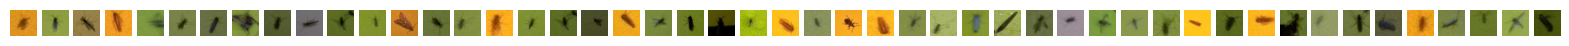

No more samples to evaluate in the pool set after iteration 1.
No more samples to select from in the pool set after 1 iterations.


In [ ]:
# Functie om de meest onzekere voorbeelden te selecteren
def select_most_uncertain(model, pool_images, device, num_samples=10):
    model.eval()
    uncertainties = []
    with torch.no_grad():
        for image in pool_images:
            prediction = model([F.to_tensor(image).to(device)])[0]
            scores = prediction['scores'].cpu().numpy()
            if len(scores) > 0:
                uncertainty = 1 - scores.max()
            else:
                uncertainty = 1.0  # No detections, high uncertainty
            uncertainties.append(uncertainty)
    
    uncertain_indices = np.argsort(uncertainties)[-num_samples:]
    return uncertain_indices

# Laad de pool set afbeeldingen
pool_images = [Image.open(os.path.join(images_dir, f)).convert('RGB') for f in pool_df['image_name']]

# Active learning iteraties
num_iterations = 5
num_samples_per_iteration = 50

for iteration in range(num_iterations):
    print(f"Iteration {iteration+1}/{num_iterations}")
    
    # Selecteer de meest onzekere voorbeelden
    uncertain_indices = select_most_uncertain(model, pool_images, device, num_samples=num_samples_per_iteration)
    selected_filenames = pool_df.iloc[uncertain_indices]['image_name'].tolist()
    
    # Annotateer de geselecteerde voorbeelden en voeg ze toe aan de trainingsset
    for filename in selected_filenames:
        annotations = process_single_image(filename, images_dir, model, device)
        for annotation in annotations:
            bbox_x2 = annotation[1] + annotation[3]
            bbox_y2 = annotation[2] + annotation[4]
            initial_train_df = initial_train_df.append({
                'image_name': annotation[0], 
                'bbox_x': annotation[1], 
                'bbox_y': annotation[2], 
                'bbox_width': bbox_x2 - annotation[1], 
                'bbox_height': bbox_y2 - annotation[2],
                'label_name': 'insect',
                'image_width': Image.open(os.path.join(images_dir, annotation[0])).width,
                'image_height': Image.open(os.path.join(images_dir, annotation[0])).height
            }, ignore_index=True)
    
    # Hertrain het model
    initial_train_images, initial_train_labels = load_images_and_labels(initial_train_df, images_dir)
    model = train_model(initial_train_images, initial_train_labels, device)
    
    # Verwijder de geselecteerde voorbeelden uit de pool set
    pool_df = pool_df[~pool_df['image_name'].isin(selected_filenames)]
    pool_images = [Image.open(os.path.join(images_dir, f)).convert('RGB') for f in pool_df['image_name']]

# Annotateer de resterende pool set
annotate_images(images_dir, model, 'annotaties_FasterRCNN.csv', device, num_workers=4)